<a href="https://colab.research.google.com/github/skandanyal/Deep_Learning/blob/main/MNIST_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Handwritten Digit Recognition

In this project, we learn how to classify hadwritten digit images using Feedforward Neural Networks.

## Importing the dataset and required libraries

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("oddrationale/mnist-in-csv")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mnist-in-csv' dataset.
Path to dataset files: /kaggle/input/mnist-in-csv


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Importing the train and test dataset sdownloaded from Kaggle

In [15]:
# reading the data files in csv format

test_data = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_test.csv")
train_data = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv")

print("Test data:\n\n",test_data[:5])
print("\n###############\n")
print("Train data:\n\n", train_data[:5])

Test data:

    label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      7    0    0    0    0    0    0    0    0    0  ...      0      0   
1      2    0    0    0    0    0    0    0    0    0  ...      0      0   
2      1    0    0    0    0    0    0    0    0    0  ...      0      0   
3      0    0    0    0    0    0    0    0    0    0  ...      0      0   
4      4    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]

###############

Train data:

    label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0

We observe that the first column contains the label, followed by 784 columns of numerically represented image data.

In [16]:
# Reshaping data

print("Reshaping data...")

train_data_final = train_data.drop(
    columns=['label'],
    axis=1
)
test_data_final = test_data.drop(
    columns=['label'],
    axis=1
)
train_labels = train_data['label']
test_labels = test_data['label']

# Normalizing the dataset

train_data_final /= 255.0
test_data_final /= 255.0

print("Data is ready!")

Reshaping data...
Data is ready!


## PyTorch

WE shall use PyTorch to implement Deep Learning methods for this project

In [17]:
# converting into PyTorch tensors

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# training dataset

X_train = torch.tensor(
    data=train_data_final.values,
    dtype=torch.float32
)
y_train = torch.tensor(
    data=train_labels.values,
    dtype=torch.long
)

# testing dataset

X_test = torch.tensor(
    data=test_data_final.values,
    dtype=torch.float32,
)
y_test = torch.tensor(
    data=test_labels.values,
    dtype=torch.long
)

We shall train the model in smaller batches to accomodate for the large dataset. (Implementing a good-practice method).

In [18]:
# using DataLoader

batch_size = 64

train_dataset = TensorDataset(
    X_train,
    y_train
)
test_dataset = TensorDataset(
    X_test,
    y_test
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

## Preparing the model

We shall build a 4 layer neural netork to perform this classification.

In [19]:
class MNIST_Model(nn.Module):
    def __init__(self):
        super(MNIST_Model, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.network(x)

In [20]:
# set up the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
torch.device(device=device)

Using device: cuda


device(type='cuda')

In [21]:
# Setting the optimizer - using Adam optimizer

model = MNIST_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    params=model.parameters(),
    lr=0.001
)

## Training loop

In [22]:
torch.manual_seed(
    seed=5
)

epochs = 50
acted_epochs = 0
train_losses = []

print("##### Training has begun #####")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        # moving the batch to the deice
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # forward pass
        output = model(X_batch)
        loss = criterion(output, y_batch)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    acted_epochs += 1

    # Logging the loss at every 4th epoch
    if (epoch+1) % 4 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss:.4f}")

    # Enabling early stopping
    if len(train_losses) > 2 and train_losses[-1] < 0.05:
        print(f"Early stopping engaged at epoch: {epoch+1}")
        break

##### Training has begun #####
Epoch [4/50] | Loss: 0.0562
Early stopping engaged at epoch: 5


/tmp/ipython-input-1233957675.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


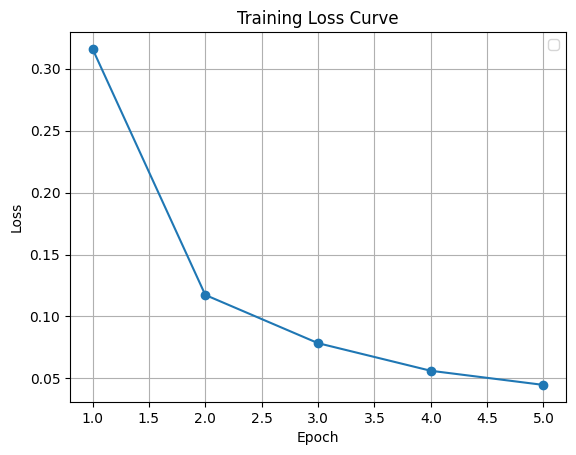

In [23]:
plt.plot(range(1, acted_epochs+1),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


## Evaluationg the model

In [24]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 97.48%
